# Alarm signal analysis

In [1]:
# Prediction margin: the only parameter to set. Recommended: margin in {5, 10, 15, 20} (aka 0.5, 1, 1.5, 2 seconds)
margin = 10

In [2]:
import pickle
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

mean = lambda l: sum(l) / len(l)

In [3]:
BASE_FP = 0.2
BASE_FN = 1


def false_positive_cost(i, is_fault, fault_found):
    return BASE_FP


def false_negative_cost(i, is_fault, fault_found):
    if not fault_found:
        for j in range(1, margin + 1):
            if i + j < is_fault.shape[0] and not is_fault[i + j] or i + j >= is_fault.shape[0]:
                return (margin + 1 - j) * BASE_FN
    else:
        return 0


# a bit ugly...
def alarm_signal_analysis(signal, thr, rul):
    alarm = list((signal >= thr))
    alarms_info = []
    good_detections = []
    
    series_range = []
    start = 0
    for i in range(len(rul) - 1):
        if rul[i] == 1 and rul[i + 1] == 0:
            series_range.append((start, i + margin))
            start = i + margin + 1

    alarms_ranges = [alarm[s[0]:s[1]] for s in series_range]
    
    for alarm_range in alarms_ranges:
        current_idx = []
        good_detection = 0
        for i in range(len(alarm_range)):
            if alarm_range[i]:
                current_idx.append(i)
                if i > len(alarm_range) - margin:
                    good_detection += 1
        alarms_info.append(current_idx)
        good_detections.append(good_detection)
    
    return alarms_info, good_detections

In [4]:
impr = ""  # "" or "impr_"
#base = "conv_nn-all_features-s2200-p11"
#base = "conv_nn-no_diff_features-s200-p2"
#base = "conv_nn-diff_features-s200-p10"
#base = "lstm-w5_features-s100-p0"
#base = "raw_signal-Ax_diff-s100-p0"
base = "mlp-w5_features-s100-p1"

file = impr + base
file2 = base

In [5]:
import pandas as pd

with open("threshold_" + str(margin) + "/" + file, "rb") as f:
    test_signal, best_thr, test_rul = pickle.load(f)
    alarms_info, good_detections = alarm_signal_analysis(test_signal, best_thr, test_rul)
    sum_alarms = [len(alarm_info) for alarm_info in alarms_info]
    
    print("Faults:", len(sum_alarms))
    print("Number of alarms:", sum(sum_alarms))
    print("Good alarms:", sum(good_detections))
    print("Number of alarms per fault:", sum_alarms)
    print("Good alarms per fault:", good_detections, "(over", margin, "possible moments)")

Faults: 13
Number of alarms: 210
Good alarms: 58
Number of alarms per fault: [34, 14, 15, 23, 23, 14, 18, 16, 7, 11, 15, 17, 3]
Good alarms per fault: [8, 2, 2, 3, 9, 4, 7, 2, 3, 6, 4, 5, 3] (over 10 possible moments)


[6, 7, 8, 9, 24, 204, 205, 206, 577, 578, 744, 1135, 1158, 1159, 1161, 1162, 1167, 1307, 1308, 1309, 1310, 1311, 1322, 1745, 2068, 2069, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080]


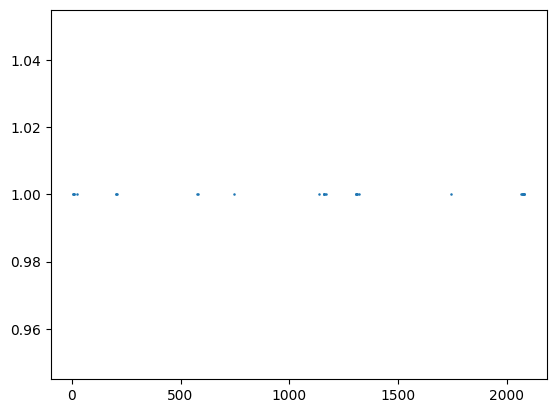

--------------------------------------------------
[411, 415, 581, 773, 945, 946, 947, 948, 949, 1173, 1174, 1175, 1311, 1312]


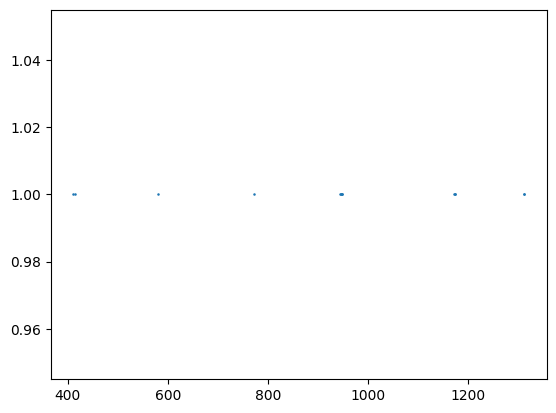

--------------------------------------------------
[22, 23, 24, 25, 26, 36, 43, 353, 354, 565, 566, 567, 568, 1041, 1042]


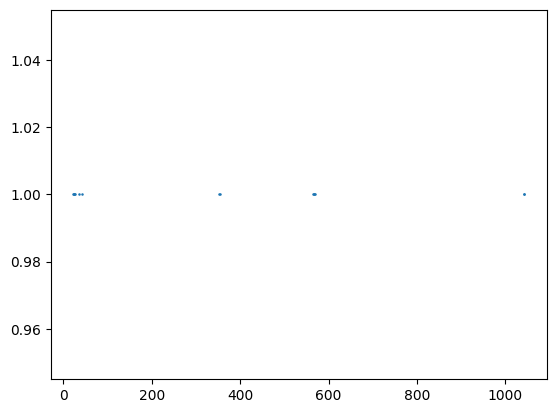

--------------------------------------------------
[201, 202, 204, 215, 408, 409, 414, 575, 576, 804, 805, 806, 807, 971, 972, 1147, 1148, 1149, 1150, 1154, 1329, 1334, 1337]


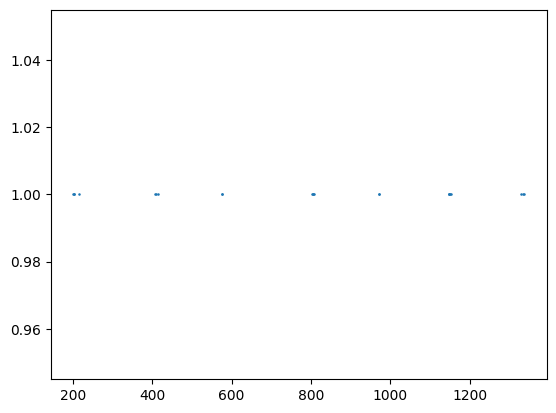

--------------------------------------------------
[28, 29, 37, 38, 395, 413, 414, 415, 566, 567, 568, 569, 570, 759, 928, 929, 930, 931, 932, 933, 934, 935, 936]


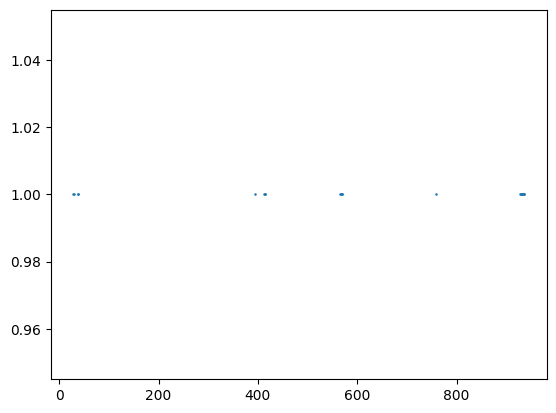

--------------------------------------------------
[32, 209, 210, 211, 212, 213, 219, 601, 602, 612, 973, 974, 975, 976]


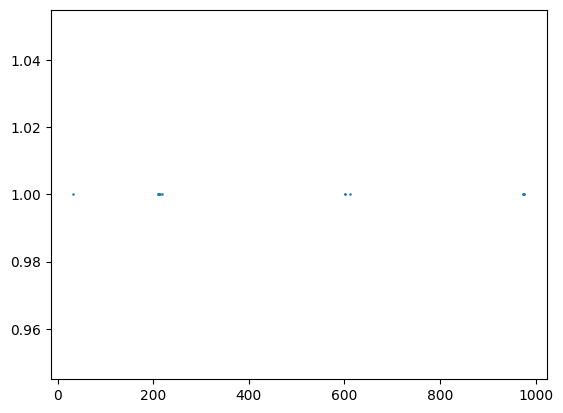

--------------------------------------------------
[394, 395, 396, 397, 398, 399, 756, 757, 758, 767, 770, 941, 942, 943, 944, 945, 946, 947]


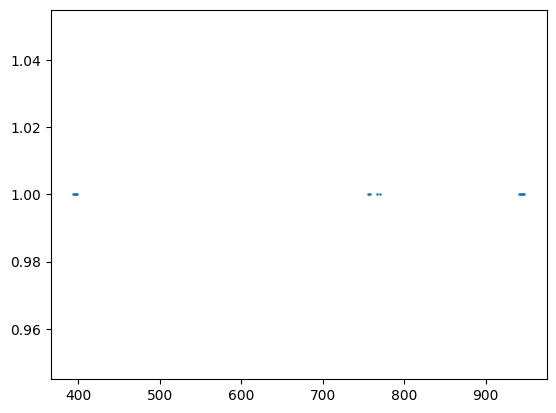

--------------------------------------------------
[25, 26, 27, 28, 206, 207, 386, 387, 575, 576, 577, 578, 579, 580, 943, 946]


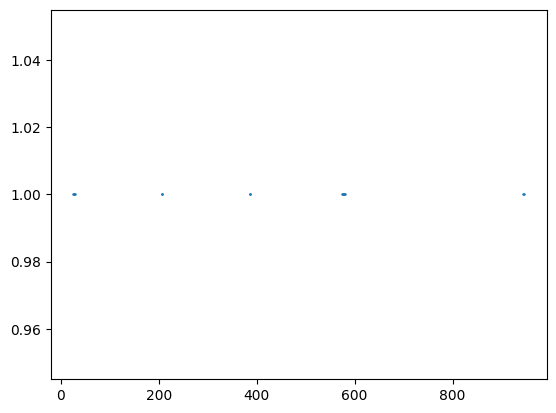

--------------------------------------------------
[10, 11, 413, 556, 931, 932, 933]


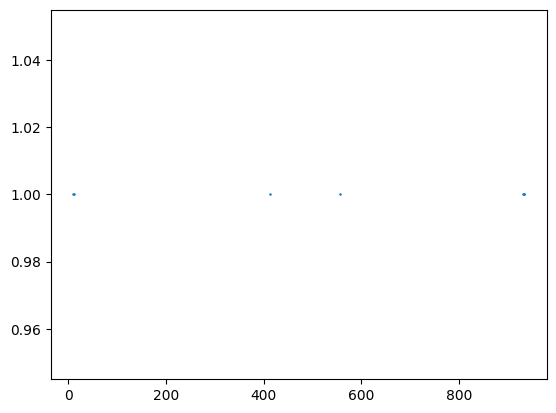

--------------------------------------------------
[212, 412, 813, 1322, 1323, 1324, 1325, 1326, 1328, 1331, 1332]


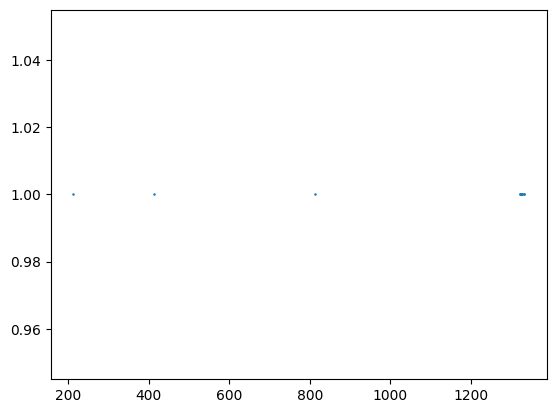

--------------------------------------------------
[202, 405, 544, 545, 546, 547, 721, 722, 723, 724, 774, 910, 911, 912, 913]


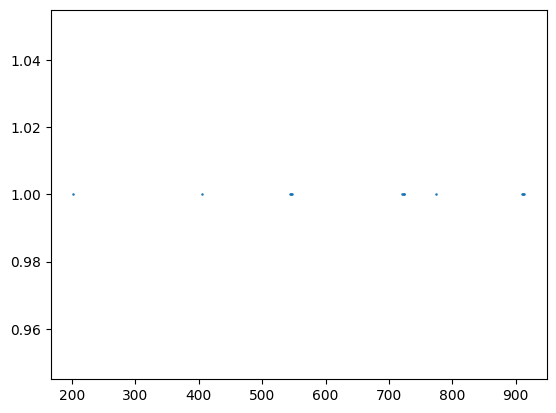

--------------------------------------------------
[413, 417, 559, 560, 561, 562, 563, 564, 565, 915, 916, 917, 918, 919, 924, 925, 926]


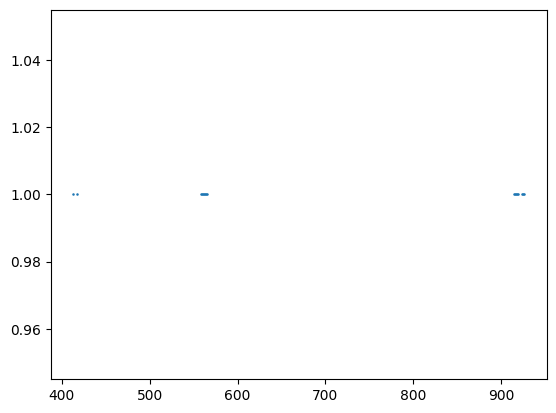

--------------------------------------------------
[216, 221, 222]


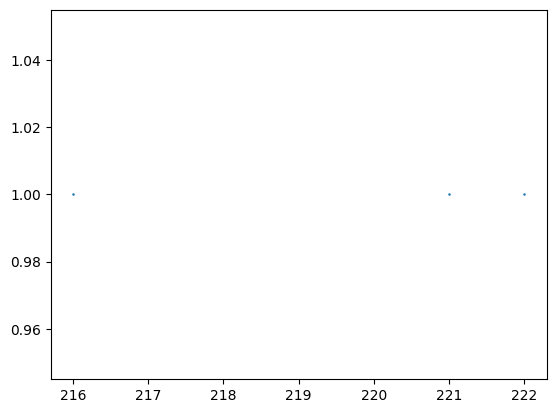

--------------------------------------------------


In [6]:
for series in alarms_info:
    print(series)
    plt.scatter(x=series, y=np.ones(len(series)), s=0.65)
    plt.show()
    print("-" * 50)

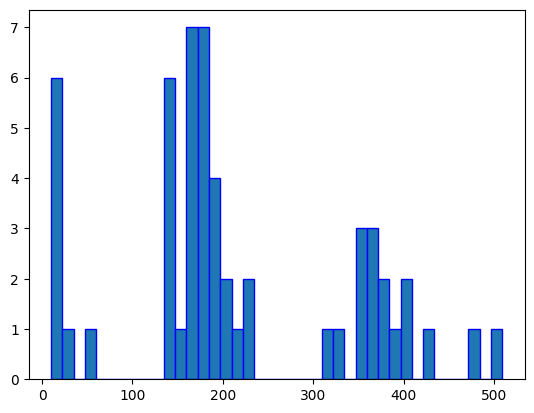

In [7]:
diffs = []
for series in alarms_info:
    diffs += list(pd.Series(series).diff().dropna())
    
diffs = [e for e in diffs if e >= margin]
    
plt.hist(diffs, bins=40, edgecolor="b")

plt.show()

In [8]:
from sklearn.neighbors import KernelDensity
import pandas as pd


# Univariate case: rule of thumb for bandwidth
diffs_pd = pd.Series(diffs)
q1 = diffs_pd.quantile(0.25)
q3 = diffs_pd.quantile(0.75)
sigma = diffs_pd.std()
m =  len(diffs_pd)
h = 0.9 * min(sigma, (q3-q1)/ 1.34) * m**(-0.2)
print(f'The estimated bandwidth is {h:.3f}')

kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(np.array(diffs).reshape(len(diffs), 1))

The estimated bandwidth is 52.078


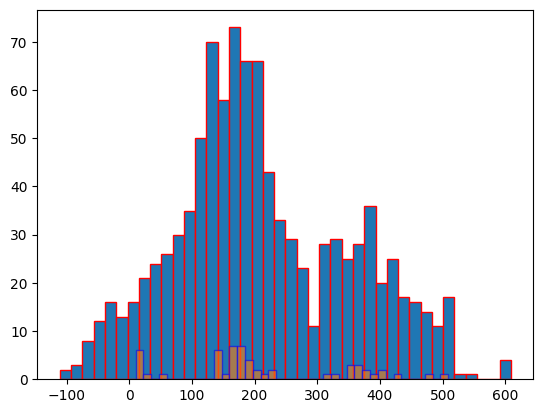

In [9]:
samples = kde.sample(n_samples=1000)

plt.hist(samples, bins=40, edgecolor="r")
plt.hist(diffs, bins=40, edgecolor="b", alpha=0.6)
plt.show()

In [10]:
kde.sample(n_samples=1)

array([[112.48058284]])

In [12]:
kde.sample(n_samples=1)

array([[194.78582276]])

In [ ]:
kde.sample(n_samples=1000)